In [140]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
import pandas as pd
pd.set_option("display.max_columns", 500)
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix

In [141]:
conn = sqlite3.connect("eia")
cursor = conn.cursor()
df = pd.DataFrame(cursor.execute("""select * from combined5""").fetchall())
df.columns = [description[0] for description in cursor.description]
df = df.drop(columns=["index", "level_0"])
df.head()

,average_ash_content,average_heat_content,average_mercury_content,average_sulfur_content,chlorine_content,coalmine_county,coalmine_msha_id,coalmine_name,coalmine_state,coalmine_type,contract_expiration_date,contract_type,energy_source,fuel_cost,fuel_group,moisture_content,month,natural_gas_delivery_contract_type,natural_gas_supply_contract_type,natural_gas_transportation_service,operator_id,operator_name,plant_id,plant_name,plant_state,primary_transportation_mode,purchase_type,quantity,regulated,reporting_frequency,secondary_transportation_mode,supplier,year,plant_id_gen,combined_heat_and_power_plant,plant_name_gen,operator_name_gen,state_gen,census_region,nerc_region,reserved_,naics_code,eia_sector_number,sector_name,reported_prime_mover,reported_fuel_type_code,aer_fuel_type_code,reserved_1,reserved_2,physical_unit_label,total_fuel_consumption_quantity,electric_fuel_consumption_quantity,total_fuel_consumption_mmbtu,elec_fuel_consumption_mmbtu,net_generation_megawatthours,year_gen,quantity_gen,elec_quantity_gen,mmbtu_per_unit_gen,tot_mmbtu_gen,elec_mmbtu_gen,netgen_gen,year_month_nerc,number_affected,disturbance_events
0,5.4,23.100,0.0,0.49,0.0,IMP,N/A,MINA PRIBBENOW,CL,SU,408.0,C,BIT,213.5,Coal,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,RV,N/A,259412,REG,M,N/A,INTEROCEAN COAL,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,4208251,4208251,94561606,94561606,9472859,2008,340778,340778,22.59,7697153,7697153,778699,2008-1-SERC,0.0,0.0
1,5.7,22.800,0.0,0.48,0.0,IMP,N/A,MINA PRIBBENOW,CL,SU,408.0,C,BIT,211.5,Coal,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,RV,N/A,52241,REG,M,N/A,INTEROCEAN COAL,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,BIT,COL,None,None,short tons,4208251,4208251,94561606,94561606,9472859,2008,340778,340778,22.59,7697153,7697153,778699,2008-1-SERC,0.0,0.0
2,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,CA,NG,NG,None,None,mcf,3433,3433,3559,3559,1609033,2008,2400,2400,1.04,2489,2489,146327,2008-1-SERC,0.0,0.0
3,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,CT,NG,NG,None,None,mcf,30932077,30932077,32090118,32090118,2858195,2008,2781102,2781102,1.04,2884003,2884003,244784,2008-1-SERC,0.0,0.0
4,0.0,1.039,0.0,0.00,0.0,N/A,N/A,None,N/A,N/A,None,C,NG,863.1,Natural Gas,0.0,1,N/A,N/A,F,195.0,Alabama Power Co,3,Barry,AL,PL,N/A,2783619,REG,M,N/A,BAY GAS PIPELINE,2008,3,N,Barry,Alabama Power Co,AL,ESC,SERC,None,22,1,Electric Utility,ST,NG,NG,None,None,mcf,837652,837652,871270,871270,87265,2008,109281,109281,1.04,113543,113543,11487,2008-1-SERC,0.0,0.0


In [142]:
coal_fields = ["fuel_cost", "average_ash_content", "average_heat_content", "average_mercury_content", "average_sulfur_content", "chlorine_content", "coalmine_county","coalmine_state", "coalmine_type", "contract_type", "energy_source", "moisture_content",  "operator_id", "plant_id", "plant_state", "primary_transportation_mode", "purchase_type", "quantity", "reporting_frequency", "secondary_transportation_mode", "supplier", "combined_heat_and_power_plant", "nerc_region", "reported_prime_mover", "net_generation_megawatthours", "mmbtu_per_unit_gen", "disturbance_events", "number_affected"]

# Checking Correlations

In [94]:
# Label encode categorical fields so that they can be correlated
df_c = df[df["fuel_group"] == "Coal"][coal_fields]
not_encode = []
to_encode = []
for fld, fld_type in df_c[coal_fields].dtypes.items():
    if "object" == fld_type:
        to_encode.append(fld)
    else:
        not_encode.append(fld)
le = LabelEncoder()
temp1 = df_c[not_encode].reset_index()
temp2 = df_c[to_encode].apply(le.fit_transform).reset_index()
df_c = temp1.merge(temp2, on="index").set_index("index")

In [95]:
corr = df_c.corr()

In [96]:
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:6]        
    for val in top_3.index:
        corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['disturbance_events', 'number_affected', 0.9253639677153023],
 ['number_affected', 'disturbance_events', 0.9253639677153023],
 ['coalmine_state', 'energy_source', 0.6261051500511815],
 ['energy_source', 'coalmine_state', 0.6261051500511815],
 ['fuel_cost', 'average_heat_content', 0.5707661703209599],
 ['average_heat_content', 'fuel_cost', 0.5707661703209599],
 ['average_heat_content', 'average_sulfur_content', 0.5374303332837997],
 ['average_sulfur_content', 'average_heat_content', 0.5374303332837997],
 ['average_ash_content', 'average_heat_content', 0.4359040238246023],
 ['average_heat_content', 'average_ash_content', 0.4359040238246023],
 ['average_heat_content', 'mmbtu_per_unit_gen', 0.4276605186448841],
 ['mmbtu_per_unit_gen', 'average_heat_content', 0.4276605186448841],
 ['average_sulfur_content', 'coalmine_type', 0.3873510421301765],
 ['coalmine_type', 'average_sulfur_content', 0.3873510421301765],
 ['average_ash_content', 'average_sulfur_content', 0.35814781332019957],
 ['aver

Some obvious correlations in here, like disturbance events and number affected (by disturbance events) similar for natural gas, or coalmine state and energy source, which is just coal type in this subset. It helps give an idea of the data, but it doesn't indicate any changes to features.

Heat content is interesting as it is possibly a major feature in determining fuel cost — potentially a direct gauge of fuel quality.

### Checking Correlations Involving Fuel Cost

In [97]:
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:]       
    for val in top_3.index:
        if col == "fuel_cost" or val == "fuel_cost":
            corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['fuel_cost', 'average_heat_content', 0.5707661703209599],
 ['fuel_cost', 'average_ash_content', 0.30212348809895695],
 ['fuel_cost', 'regulated', nan],
 ['average_heat_content', 'fuel_cost', 0.5707661703209599],
 ['average_ash_content', 'fuel_cost', 0.30212348809895695],
 ['fuel_cost', 'operator_id', 0.28714814295651925],
 ['operator_id', 'fuel_cost', 0.28714814295651925],
 ['fuel_cost', 'mmbtu_per_unit_gen', 0.23997196994779615],
 ['mmbtu_per_unit_gen', 'fuel_cost', 0.23997196994779615],
 ['fuel_cost', 'chlorine_content', 0.23149250910755437],
 ['chlorine_content', 'fuel_cost', 0.23149250910755437],
 ['fuel_cost', 'average_sulfur_content', 0.08942996342699425],
 ['average_sulfur_content', 'fuel_cost', 0.08942996342699425],
 ['fuel_cost', 'contract_type', 0.07305368428019887],
 ['contract_type', 'fuel_cost', 0.07305368428019887],
 ['fuel_cost', 'supplier', 0.05575496208195469],
 ['supplier', 'fuel_cost', 0.05575496208195469],
 ['fuel_cost', 'average_mercury_content', 0.05286164599131

Heat and ash content decently correlated with fuel cost makes sense as those can be direct factors of fuel quality for coal. Operator may be interesting to explore later.

Chlorine content is also interesting as it involves coal and environmental regulation.

# Modelling

In [143]:
def get_c():
    df_c = df[df["fuel_group"] == "Coal"][coal_fields]
    not_encode = []
    to_encode = []
    for fld, fld_type in df_c[coal_fields].dtypes.items():
        if "object" == fld_type:
            to_encode.append(fld)
        else:
            not_encode.append(fld)
    temp1 = df_c[not_encode].reset_index()
    temp2 = pd.get_dummies(df_c[to_encode]).reset_index()
    df_c = temp1.merge(temp2, on="index").set_index("index")
    return df_c


In [144]:
df_c = get_c()

In [145]:
X = df_c.drop(columns=["fuel_cost"])
y = (df_c.fuel_cost > df_c.fuel_cost.quantile(.9))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [146]:
model = DecisionTreeClassifier(random_state=23)
results = model.fit(X_train, y_train)

In [147]:
results.score(X_test, y_test)

0.9612560878098423

In [148]:
cross_val_score(results, X, y, cv=5)

array([0.8314374 , 0.93403358, 0.92458111, 0.65310944, 0.90059245])

Some inconsistencies in cross_val_score. May need SMOTE because of data imbalance.

In [8]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

average_heat_content 0.1496364566848914
average_sulfur_content 0.10205548685898544
net_generation_megawatthours 0.059381975088542545
quantity 0.04852199668320226
average_ash_content 0.04335378698783672
mmbtu_per_unit_gen 0.04116329520442432
operator_id_7140.0 0.03077372659431183
nerc_region_RFC 0.024317040997224735
contract_type_S 0.016889465708398943
contract_type_N/A 0.0161594928323516
nerc_region_WECC 0.01473935543047256
average_mercury_content 0.01390048110644933
coalmine_type_P 0.01223138914638515
plant_state_VA 0.008701876031192568
supplier_JP MORGAN VENTURES ENERGY 0.007837232858676671
supplier_Massey 0.0077532759317920285
coalmine_state_KY 0.007181866063745331
operator_id_4254.0 0.0067910574183917705
supplier_ALPHA COAL 0.0066744689433591055
operator_id_5416.0 0.006573419133907535
operator_id_7801.0 0.0063802766306169986
supplier_TRINITY COAL 0.006061958320750849
purchase_type_C 0.00558270104403832
plant_id_2364 0.005343388756960063
operator_id_18642.0 0.005326220910214584
coal

coalmine_county_129 0.0
coalmine_county_129.0 0.0
coalmine_county_13.0 0.0
coalmine_county_133.0 0.0
coalmine_county_135 0.0
coalmine_county_139 0.0
coalmine_county_145 0.0
coalmine_county_145.0 0.0
coalmine_county_147 0.0
coalmine_county_149 0.0
coalmine_county_15 0.0
coalmine_county_15.0 0.0
coalmine_county_157.0 0.0
coalmine_county_159.0 0.0
coalmine_county_163 0.0
coalmine_county_165.0 0.0
coalmine_county_167 0.0
coalmine_county_17 0.0
coalmine_county_177 0.0
coalmine_county_177.0 0.0
coalmine_county_183 0.0
coalmine_county_183.0 0.0
coalmine_county_189 0.0
coalmine_county_19.0 0.0
coalmine_county_195.0 0.0
coalmine_county_203 0.0
coalmine_county_203.0 0.0
coalmine_county_217 0.0
coalmine_county_225.0 0.0
coalmine_county_23 0.0
coalmine_county_233 0.0
coalmine_county_233.0 0.0
coalmine_county_235 0.0
coalmine_county_235.0 0.0
coalmine_county_237 0.0
coalmine_county_25.0 0.0
coalmine_county_27.0 0.0
coalmine_county_290 0.0
coalmine_county_3 0.0
coalmine_county_3.0 0.0
coalmine_count

supplier_GOFF 0.0
supplier_GOLDEN EAGLE INC. 0.0
supplier_GREG'S TRUCK SERVICE 0.0
supplier_GTM MINING 0.0
supplier_GTS CARBON 0.0
supplier_GUASARE 0.0
supplier_GULF 0.0
supplier_GULF POWER COMPANY 0.0
supplier_GULF TRADING & TRANSPORT 0.0
supplier_Gatling 0.0
supplier_Geary 11 Mine 0.0
supplier_Global Coal 0.0
supplier_HAROLD KEENE COAL COMPANY, INC 0.0
supplier_HARRIS 0.0
supplier_HAYSTACK 0.0
supplier_HIAWATHA COAL CO 0.0
supplier_HIDDEN SPLENDOR RESOURCES 0.0
supplier_HILL MINE 0.0
supplier_HILO 0.0
supplier_HOLBROOK COAL 0.0
supplier_HOPEDALE MINING 0.0
supplier_HOPKINS COUNTY COAL 0.0
supplier_HORIZON 0.0
supplier_HUDSON TRUCKING 0.0
supplier_HUNTS BRANCH 0.0
supplier_HWP, LLC 0.0
supplier_Hill's Fuels 0.0
supplier_I&M 0.0
supplier_IBCS MINING 0.0
supplier_ICG Illinois LLC 0.0
supplier_ICG, LLC 0.0
supplier_ICG, LLC                 BIRCH RIVER MIN 0.0
supplier_IGC HAZARD 0.0
supplier_IGS ENERGY 0.0
supplier_ILLINI ENVIRONMENTAL 0.0
supplier_ILLINOIS FUELS 0.0
supplier_IMAGIN NATU

In [149]:
y_pred = results.predict(X_test)

In [150]:
f1_score(y_test, y_pred)

0.7987919969799925

In [108]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred))

In [109]:
conf

,0,1
0,24137,563
1,568,2246


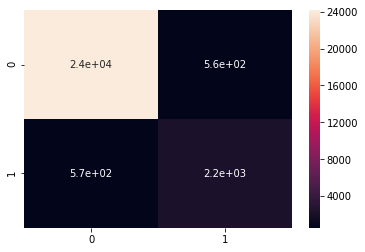

In [110]:
sns.heatmap(conf, annot=True)

F1 score without SMOTE is decent, but applying SMOTE anyway to try and improve.

In [112]:
# Show imbalance of data
len(df_c[df_c.fuel_cost > df_c.fuel_cost.quantile(.9)])/len(df_c)

0.0999941846941149

# Neural Net

In [109]:
df_c = get_c()
df_c.shape

(137568, 1835)

In [112]:
from keras.models import Sequential
from keras import layers

In [117]:
model = Sequential()
model.add(layers.Dense(50, activation='relu', input_shape=(1834,)))
model.add(layers.Dense(1, activation='relu'))
model.add(layers.Dropout(0.3))

In [135]:
model.compile(loss='binary_crossentropy', optimizer="SGD", metrics=['binary_accuracy'])

In [132]:
X = df_c.drop(columns=["fuel_cost"])
y = (df_c.fuel_cost > df_c.fuel_cost.quantile(.9))*1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [136]:
history = model.fit(X_train, y_train, epochs=120, batch_size=256)


Epoch 1/120
110054/110054 [==============================] - 16s 148us/step - loss: 1.6548 - binary_accuracy: 0.8969
Epoch 2/120
110054/110054 [==============================] - 14s 129us/step - loss: 1.6532 - binary_accuracy: 0.8969
Epoch 3/120
110054/110054 [==============================] - 14s 131us/step - loss: 1.6551 - binary_accuracy: 0.8969
Epoch 4/120
110054/110054 [==============================] - 14s 131us/step - loss: 1.6542 - binary_accuracy: 0.8969
Epoch 5/120
110054/110054 [==============================] - 15s 133us/step - loss: 1.6538 - binary_accuracy: 0.8969
Epoch 6/120
110054/110054 [==============================] - 16s 149us/step - loss: 1.6537 - binary_accuracy: 0.8969
Epoch 7/120
110054/110054 [==============================] - 16s 143us/step - loss: 1.6567 - binary_accuracy: 0.8968
Epoch 8/120
110054/110054 [==============================] - 15s 140us/step - loss: 1.6532 - binary_accuracy: 0.8969
Epoch 9/120
110054/110054 [==============================] - 16s

KeyboardInterrupt: 

In [137]:
y_pred = model.predict(X_test)

# Modelling with SMOTE

In [11]:
df_c = get_c()

In [12]:
X = df_c.drop(columns=["fuel_cost"])
y = (df_c.fuel_cost > df_c.fuel_cost.quantile(.9))

In [13]:
df_c.chlorine_content = df_c.chlorine_content.fillna(value=0)

In [15]:
sm = SMOTE()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [16]:
model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

In [17]:
y_pred = results.predict(X_test)

In [18]:
f1_score(y_test, y_pred)

0.5779578971068333

Much better F1-score. But let's see if we can improve.

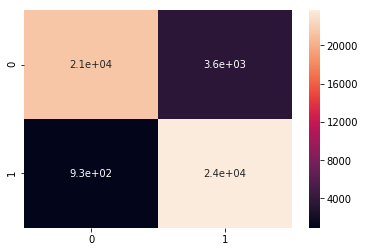

In [117]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(conf, annot=True)

In [118]:
conf

,0,1
0,21359,3572
1,927,23667


In [119]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

average_heat_content 0.4138000002893433
average_sulfur_content 0.1542076959237902
energy_source_SUB 0.04989753006063164
nerc_region_RFC 0.042740732681275546
nerc_region_WECC 0.03221462776716444
net_generation_megawatthours 0.02872327515735615
contract_type_S 0.023302712752550532
primary_transportation_mode_RR 0.02063705471543314
purchase_type_S 0.017066291323083356
coalmine_type_U 0.015230388349066964
coalmine_state_WV 0.014629463096455707
plant_id_7213 0.01207017914878687
supplier_JP MORGAN VENTURES ENERGY 0.011317919346849805
plant_state_ND 0.008904640308253352
plant_state_KY 0.007736597774987222
coalmine_county_059 0.006930693806312782
supplier_TRINITY COAL 0.006777793764072239
coalmine_type_P 0.006674349679707959
mmbtu_per_unit_gen 0.006619208165915781
plant_id_2364 0.005379376059490844
plant_state_NC 0.004653504666870398
operator_id_19876.0 0.004078265831071631
supplier_MARSHALL RESOURCES 0.0039951664052007285
primary_transportation_mode_N/A 0.0039141831423296835
operator_id_18642

plant_id_6138 0.0
plant_id_6139 0.0
plant_id_6155 0.0
plant_id_6165 0.0
plant_id_6166 0.0
plant_id_6170 0.0
plant_id_6177 0.0
plant_id_6179 0.0
plant_id_6181 0.0
plant_id_6183 0.0
plant_id_6190 0.0
plant_id_6193 0.0
plant_id_6194 0.0
plant_id_6195 0.0
plant_id_6204 0.0
plant_id_6213 0.0
plant_id_6248 0.0
plant_id_6249 0.0
plant_id_6250 0.0
plant_id_6254 0.0
plant_id_6257 0.0
plant_id_6264 0.0
plant_id_6288 0.0
plant_id_641 0.0
plant_id_642 0.0
plant_id_643 0.0
plant_id_6469 0.0
plant_id_6481 0.0
plant_id_663 0.0
plant_id_6639 0.0
plant_id_6641 0.0
plant_id_6664 0.0
plant_id_667 0.0
plant_id_676 0.0
plant_id_6761 0.0
plant_id_6768 0.0
plant_id_6772 0.0
plant_id_6823 0.0
plant_id_7 0.0
plant_id_703 0.0
plant_id_708 0.0
plant_id_7097 0.0
plant_id_710 0.0
plant_id_7210 0.0
plant_id_7242 0.0
plant_id_727 0.0
plant_id_728 0.0
plant_id_733 0.0
plant_id_7343 0.0
plant_id_7504 0.0
plant_id_7537 0.0
plant_id_7737 0.0
plant_id_7790 0.0
plant_id_7902 0.0
plant_id_8 0.0
plant_id_8023 0.0
plant_id_8

supplier_OMEGA HOLDING,LLC 0.0
supplier_OMNI COAL GROUP 0.0
supplier_OPCO 0.0
supplier_ORLANDO UTILITIES 0.0
supplier_OTTER RESOURCES 0.0
supplier_OVEC POWER 0.0
supplier_OXBOW CARBON INTERNATIONA 0.0
supplier_OXBOW MINING 0.0
supplier_OXFORD MINING 0.0
supplier_OXFORD MINING CO. 0.0
supplier_OXFORD MINING COMPANY 0.0
supplier_OXFORD MINING COMPANY    ADAMSVILLE 0.0
supplier_Ohio American 0.0
supplier_Oxbow 0.0
supplier_Oxford 0.0
supplier_P & M COAL 0.0
supplier_PANTHER CREEK 0.0
supplier_PARDEE 0.0
supplier_PASO DIABLO 0.0
supplier_PATRIOT COAL SALES LLC   COLABURG NO. 2 0.0
supplier_PATRIOT II 0.0
supplier_PATRIOT MINE 0.0
supplier_PATTERSON 0.0
supplier_PATTIKI 0.0
supplier_PAX 0.0
supplier_PBP ENERGY 0.0
supplier_PBP Energy LLC 0.0
supplier_PBS COALS 0.0
supplier_PEABODY 0.0
supplier_PEABODY COAL 0.0
supplier_PEABODY COAL SALES, LLC 0.0
supplier_PEAK COAL SALES 0.0
supplier_PEERLESS 0.0
supplier_PEERLESS MINERALS LLC 0.0
supplier_PENN OHIO 0.0
supplier_PERRY COUNTY 0.0
supplier_PE

# Analyze False Positives and Negatives

In [151]:
# Reload data label-encoded for correlation
# Label encode categorical fields so that they can be correlated
df_c = df[df["fuel_group"] == "Coal"][coal_fields]
not_encode = []
to_encode = []
for fld, fld_type in df_c[coal_fields].dtypes.items():
    if "object" == fld_type:
        to_encode.append(fld)
    else:
        not_encode.append(fld)
le = LabelEncoder()
temp1 = df_c[not_encode].reset_index()
temp2 = df_c[to_encode].apply(le.fit_transform).reset_index()
df_c = temp1.merge(temp2, on="index").set_index("index")

In [152]:
y_pred = results.predict(X)

In [153]:
wrongs = (y_pred != y)

### Append the wrong flag on the dataframe so we can analyze and subset

In [154]:
df_c["wrong"] = wrongs

In [155]:
df_c = df_c[df_c["wrong"] == True].drop(columns="wrong")

### Correlations on the Dataset of Innaccurate Predictions

In [156]:
corr = df_c.corr()
corrs = []
for col in corr.columns:
    top_3 = corr[col].sort_values(ascending=False)[1:]       
    for val in top_3.index:
        if col == "fuel_cost" or val == "fuel_cost":
            corrs.append([col, val, top_3[val]])

corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
corrs[0:20]  

[['fuel_cost', 'mmbtu_per_unit_gen', 0.09474135134932993],
 ['mmbtu_per_unit_gen', 'fuel_cost', 0.09474135134932993],
 ['fuel_cost', 'operator_id', 0.09183841572274025],
 ['operator_id', 'fuel_cost', 0.09183841572274025],
 ['fuel_cost', 'plant_id', 0.0780399094985484],
 ['plant_id', 'fuel_cost', 0.0780399094985484],
 ['fuel_cost', 'average_heat_content', 0.05826897535893543],
 ['average_heat_content', 'fuel_cost', 0.05826897535893543],
 ['fuel_cost', 'contract_type', 0.05365717704214404],
 ['contract_type', 'fuel_cost', 0.05365717704214404],
 ['fuel_cost', 'net_generation_megawatthours', 0.027302153723684743],
 ['net_generation_megawatthours', 'fuel_cost', 0.027302153723684743],
 ['fuel_cost', 'moisture_content', 0.02586111594842036],
 ['moisture_content', 'fuel_cost', 0.02586111594842036],
 ['fuel_cost', 'average_mercury_content', 0.0218392347788997],
 ['average_mercury_content', 'fuel_cost', 0.0218392347788997],
 ['fuel_cost', 'coalmine_county', 0.015959408711792564],
 ['coalmine_cou

Largest correlation of inaccurate predictions involves chlorine content. But looking at other top correlations too.

In [179]:
df_c["coalmine_state"].value_counts()

10    6971
28    4822
21    1039
4      938
26     918
1      877
6      762
3      606
7      490
23     222
25     204
18     175
12     122
14     120
11     100
24      93
29      83
0       69
20      38
27      37
13      25
15      17
5        1
8        1
17       1
16       1
Name: coalmine_state, dtype: int64

In [128]:
df_c["energy_source"].value_counts()

0    18728
1      139
3       55
4       12
2        1
Name: energy_source, dtype: int64

# KMeans Clustering to Identify Inaccurate Data Needing Separate Model

In [40]:
df_c = get_c()

In [44]:
df_c["wrong"] = wrongs

In [47]:
df_c = df_c[df_c["wrong"] == True]

In [41]:
from sklearn.cluster import KMeans

In [90]:
kmean = KMeans(n_clusters=5)

In [91]:
results = kmean.fit(df_c)

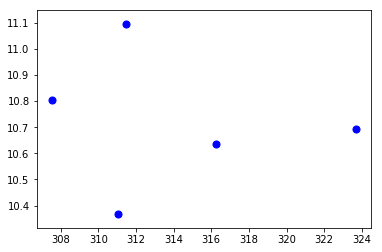

In [92]:
centers= results.cluster_centers_
plt.scatter(centers[ : , 0], centers[ : , 1], s =50, c='b')

In [93]:
#from collections import Counter
Counter(results.labels_)

Counter({4: 2967, 2: 6695, 1: 5052, 3: 3544, 0: 257})

In [94]:
df_c["cluster"] = kmean.labels_

In [95]:
df_c1 = df_c[df_c.cluster == 1]

In [96]:
X = df_c1.drop(columns="fuel_cost")
y = (df_c1.fuel_cost > df_c.fuel_cost.quantile(.9))

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [98]:
model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

In [99]:
y_pred = results.predict(X_test)

In [100]:
f1_score(y_test, y_pred)

0.6919431279620853

# Subsetting the Data - Where Chlorine Content > 0

In [101]:
df_c = get_c()
df_c2 = df_c[(df_c["chlorine_content"] >0)]

In [102]:
X = df_c2.drop(columns="fuel_cost")
y = (df_c2.fuel_cost > df_c.fuel_cost.quantile(.9))

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [104]:
model = DecisionTreeClassifier(random_state=23, max_depth=10)
results = model.fit(X_train, y_train)

In [105]:
y_pred = results.predict(X_test)

In [30]:
f1_score(y_test, y_pred)

0.7777777777777778

Great F1-score on the subset.

In [31]:
leaf1_test = y_test
leaf1_pred = y_pred

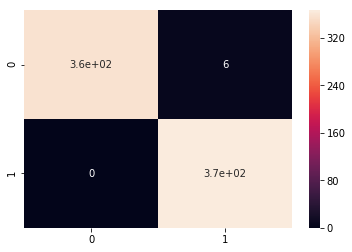

In [195]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(conf, annot=True)

In [137]:
conf

,0,1
0,70,1
1,7,54


In [197]:
cross_val_score(results, X_res, y_res, cv=20)

array([0.91304348, 0.98901099, 0.99450549, 0.99450549, 1.        ,
       0.98901099, 1.        , 1.        , 1.        , 1.        ,
       0.98901099, 0.98901099, 0.99450549, 0.99450549, 0.98901099,
       0.98901099, 0.98351648, 1.        , 0.96703297, 0.99450549])

No abberations in cross_val_score

# Modeling Subset of Data - Chlorine Content == 0

In [32]:
df_c = get_c()
df_c3 = df_c[(df_c["chlorine_content"] <=0)]

In [34]:
X = df_c3.drop(columns="fuel_cost")
y = (df_c3.fuel_cost > df_c.fuel_cost.quantile(.9))
#sm = SMOTE()
#X_res, y_res = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [35]:
model = DecisionTreeClassifier()
results = model.fit(X_train, y_train)

In [36]:
y_pred = results.predict(X_test)
f1_score(y_pred, y_test)

0.7988505747126438

Better F1 score here

In [37]:
leaf2_pred = y_pred
leaf2_test = y_test

In [203]:
for a,b in sorted(zip(X.columns, results.feature_importances_), key=lambda x: x[1], reverse=True):
    print(a,b)

coalmine_type_S 0.25746148430269966
primary_transportation_mode_TC 0.1519356165779462
nerc_region_RFC 0.12085401282375548
plant_state_KY 0.09180180081345145
primary_transportation_mode_TR 0.033759069771913536
average_ash_content 0.026798904179519606
coalmine_state_IL 0.025340739156179456
operator_id_3046.0 0.023285893585766358
coalmine_state_KY 0.0223494932351183
supplier_NEW HORIZON MINE 0.020911040832418085
average_sulfur_content 0.020852705518259924
coalmine_county_193 0.019937224697305456
plant_state_UT 0.01743417152109215
coalmine_county_159 0.016099932109040992
coalmine_county_5 0.013236829177078396
plant_id_2721 0.013143521765167738
supplier_ALPHA COAL 0.012886180903997556
supplier_PEABODY COAL 0.011225046141701606
coalmine_county_59 0.010475347003022049
average_heat_content 0.010019499570997967
coalmine_state_IN 0.009959851874143612
plant_state_ND 0.008372819725501164
supplier_CONSOL 0.007233101430650296
operator_id_18642.0 0.005031241867268241
plant_state_SC 0.0047271096726116

plant_id_6031 0.0
plant_id_6034 0.0
plant_id_6041 0.0
plant_id_6052 0.0
plant_id_6061 0.0
plant_id_6064 0.0
plant_id_6065 0.0
plant_id_6068 0.0
plant_id_6071 0.0
plant_id_6073 0.0
plant_id_6077 0.0
plant_id_6085 0.0
plant_id_6089 0.0
plant_id_6090 0.0
plant_id_6095 0.0
plant_id_6096 0.0
plant_id_6098 0.0
plant_id_6101 0.0
plant_id_6106 0.0
plant_id_6113 0.0
plant_id_6124 0.0
plant_id_6136 0.0
plant_id_6137 0.0
plant_id_6138 0.0
plant_id_6139 0.0
plant_id_6155 0.0
plant_id_6165 0.0
plant_id_6166 0.0
plant_id_6170 0.0
plant_id_6177 0.0
plant_id_6179 0.0
plant_id_6181 0.0
plant_id_6183 0.0
plant_id_6190 0.0
plant_id_6193 0.0
plant_id_6194 0.0
plant_id_6195 0.0
plant_id_6204 0.0
plant_id_6213 0.0
plant_id_6248 0.0
plant_id_6249 0.0
plant_id_6250 0.0
plant_id_6254 0.0
plant_id_6257 0.0
plant_id_6264 0.0
plant_id_628 0.0
plant_id_6288 0.0
plant_id_641 0.0
plant_id_642 0.0
plant_id_643 0.0
plant_id_6469 0.0
plant_id_6481 0.0
plant_id_663 0.0
plant_id_6641 0.0
plant_id_6664 0.0
plant_id_667 0.

supplier_JAVELIN GLOBAL COMMODITIES 0.0
supplier_JB MINERALS 0.0
supplier_JEFFERIES GROUP LLC 0.0
supplier_JERA TRADING NORTH AMERICA, LLC 0.0
supplier_JERRY WHITE?S RECLAMATION SITE 0.0
supplier_JESSE BRANCH 0.0
supplier_JESSE CREEK MINING 0.0
supplier_JIM BRIDGER COAL 0.0
supplier_JIM WALTER 0.0
supplier_JM ADAMS 0.0
supplier_JONES FORK 0.0
supplier_JP MORGAN VENTURES ENERGY 0.0
supplier_JP Morgan 0.0
supplier_JRL COAL LLC 0.0
supplier_KAJON 0.0
supplier_KCBX TERMINAL 0.0
supplier_KELLY MINE 0.0
supplier_KEN AMERICAN 0.0
supplier_KENAMERICA RESOURCES 0.0
supplier_KENNECOTT COAL SALES 0.0
supplier_KENNECOTT ENERGY 0.0
supplier_KENTUCKY COAL 0.0
supplier_KENTUCKY CUMBERLAND 0.0
supplier_KENTUCKY ENERGY SALES LLCBOWIE #2 0.0
supplier_KENTUCKY FUELS 0.0
supplier_KENTUCKY MINING 0.0
supplier_KENTUCKY UTILITIES 0.0
supplier_KENTUCKYFU 0.0
supplier_KEYSTONE 0.0
supplier_KEYSTONE COAL 0.0
supplier_KEYSTONE INDUSTRIES 0.0
supplier_KIEWIT - BUCKSKIN 0.0
supplier_KIMBLE COMPANY 0.0
supplier_KIN

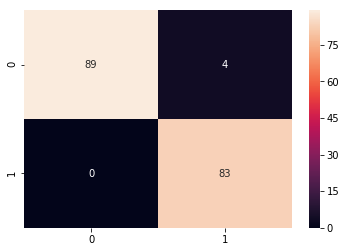

In [147]:
conf = pd.DataFrame(confusion_matrix(y_test, y_pred))
sns.heatmap(conf, annot=True)

In [148]:
conf

,0,1
0,89,4
1,0,83


# Combine the Two Leafs to Find Out Combined F1 Score

In [38]:
leaf1_pred = pd.DataFrame(leaf1_pred)
leaf2_pred = pd.DataFrame(leaf2_pred)
leaf1_test = pd.DataFrame(leaf1_test)
leaf2_test = pd.DataFrame(leaf2_test)

leafs_pred = leaf1_pred.append(leaf2_pred)
leafs_test = leaf1_test.append(leaf2_test)

In [39]:
f1_score(leafs_pred, leafs_test)

0.7987826709631219

In [209]:
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG

In [211]:
from IPython.display import display                               
from ipywidgets import interactive

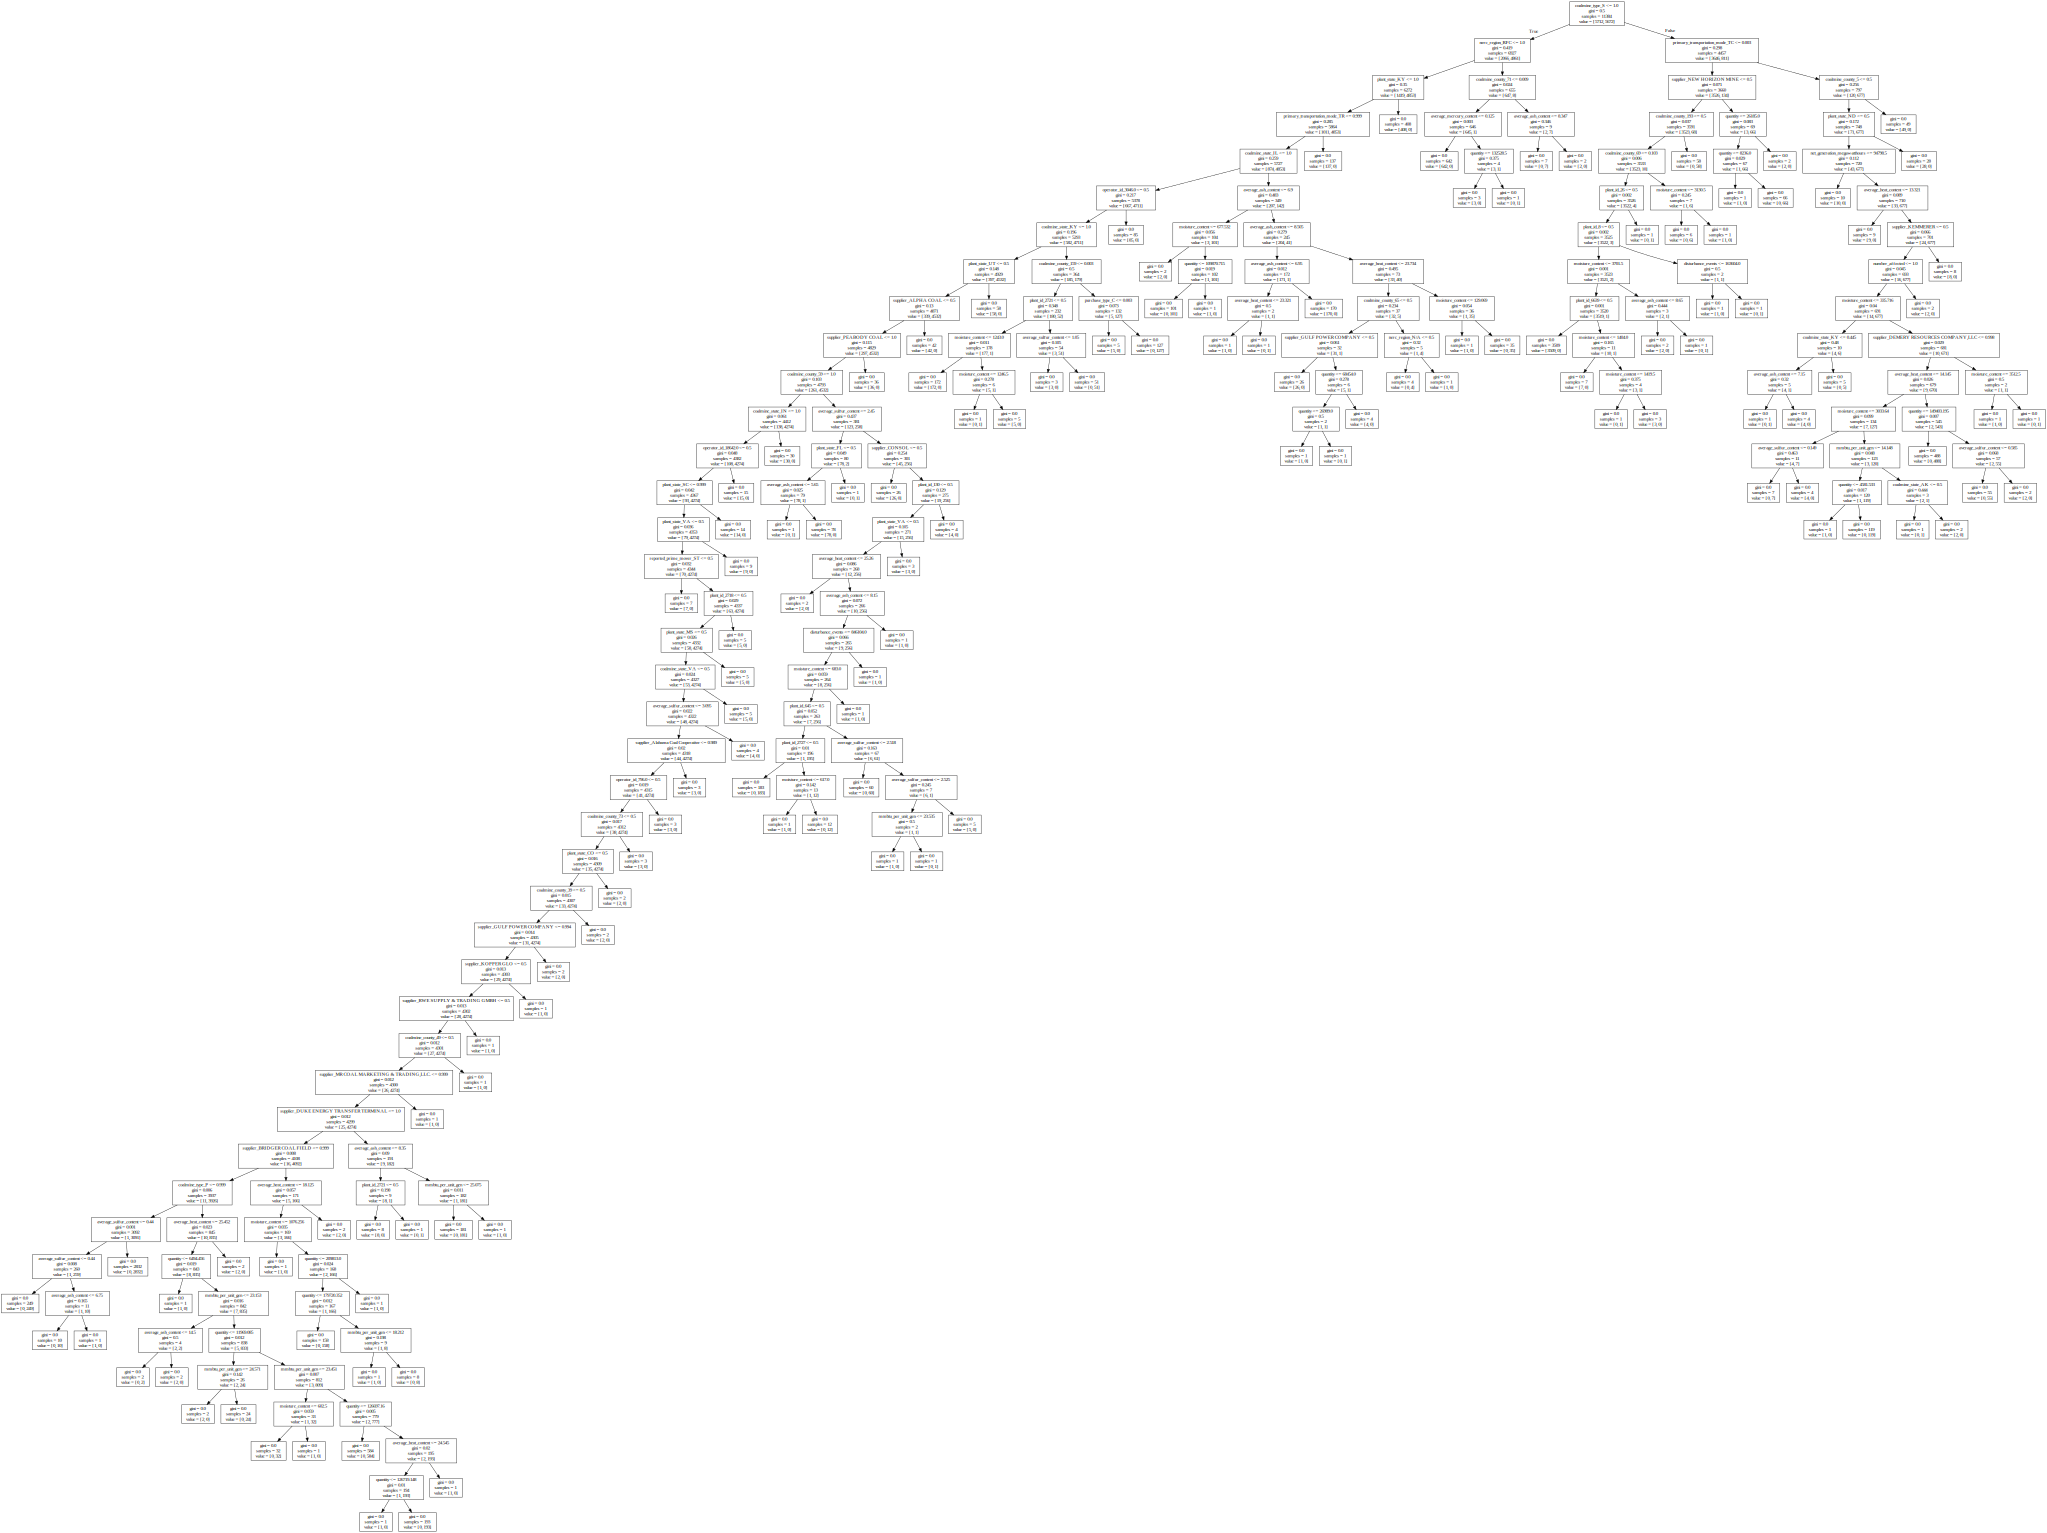

In [210]:
graph = Source(export_graphviz(results, out_file=None, feature_names=X.columns))
SVG(graph.pipe(format='svg'))

In [ ]:
graph.format = 'png'
graph.render('dtree_render',view=True)